In [59]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import torch 
import os
import cv2
from PIL import Image
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,random_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

Clean Data

In [60]:
device=torch.device("cuda")

In [61]:
data_dir="data"

In [62]:
def get_image_formats(folder):
    formats = set()
    for root, _, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            try:
                with Image.open(path) as img:
                    formats.add(img.format)
            except:
                pass
    return formats

folder = "data"
print(get_image_formats(folder))

{'PNG'}


In [63]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [64]:
count=0
for img_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,img_class)):
        img_path=os.path.join(data_dir,img_class,image)
        try:
            op=cv2.imread(img_path)
            img = Image.open(img_path) 
            ty = img.format.lower()
            if ty not in image_exts:
                print('Image not in ext list {}'.format(img_path))
                os.remove(img_path)
                count+=1
        except:    
             print('Issue with image {}'.format(img_path))
             os.remove(img_path)
             count+=1
print(count)             

0


In [65]:
transform = transforms.Compose([
    transforms.Resize((224,224)),     
    transforms.ToTensor(),             
    transforms.Normalize(              
        mean=[0.485, 0.456, 0.406],   
        std=[0.229, 0.224, 0.225]      
    )
])


In [66]:
dataset=datasets.ImageFolder(root=data_dir,transform=transform)

In [67]:
data_lo=DataLoader(dataset,batch_size=16,shuffle=True)

In [68]:
data_iter = iter(data_lo)  
images, labels = next(data_iter)
print(images.shape)  
print(labels[:16])  


torch.Size([16, 3, 224, 224])
tensor([0, 1, 1, 0, 1, 0, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


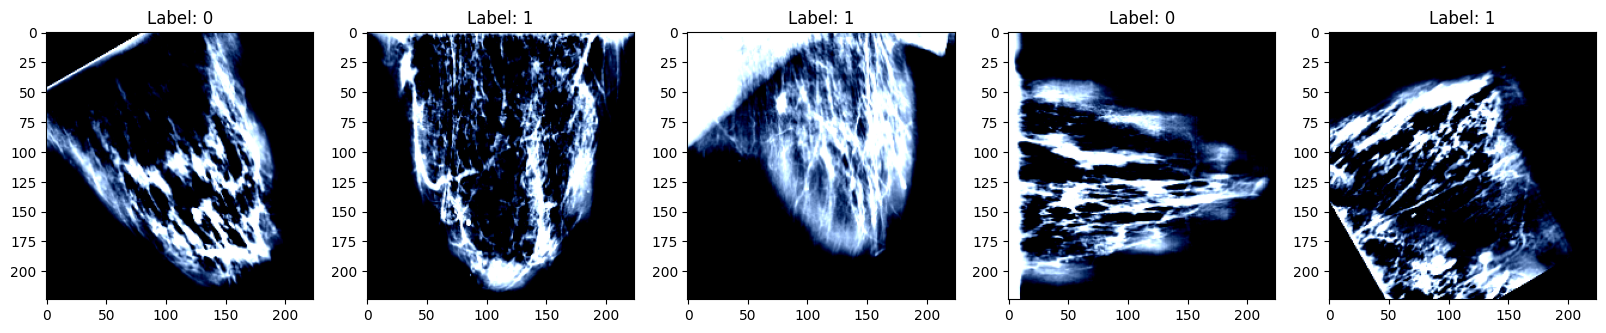

In [69]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 20))

for i in range(5):
    img = images[i].permute(1, 2, 0)  # (H, W, C)
    ax[i].imshow(img)
    ax[i].set_title(f"Label: {labels[i].item()}")

plt.show()

In [70]:
int(len(dataset))

9198

In [71]:

train_data_s=int(.7*len(dataset))
val_data_s=int(.15*len(dataset))
test_data_s=int(len(dataset))-train_data_s-val_data_s
#-----------------------------------------------------------------------------------------------------
seed = 42  
generator = torch.Generator().manual_seed(seed)

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_data_s, val_data_s, test_data_s],
    generator=generator
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



In [72]:
print(train_data_s,test_data_s,val_data_s)

6438 1381 1379


In [73]:
net=models.resnet18(pretrained=True)    
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 3)

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_counts = [3660,3689,2000]
weights = [1.0 / c for c in class_counts]  
weights = torch.tensor(weights, dtype=torch.float32)
weights = torch.tensor(weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

#-------------------------------------------------------------------------------
optimizer = optim.Adam(net.parameters(), lr=.00001)


C:\Users\Cc\AppData\Local\Temp\ipykernel_15248\4072098412.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights, dtype=torch.float32).to(device)


In [75]:
net.to(device)
torch.cuda.manual_seed(42)
eposhs =6
accs=[]
train_losses = []
test_losses = []
eposhs_count = []

for epoch in range(eposhs):
    net.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    
    # -------- Evaluation --------
    net.eval()
   
    running_test_loss, correct = 0.0, 0   
    with torch.no_grad():
        
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    
    acc = correct / len(val_loader.dataset)

    test_loss = running_test_loss / len(val_loader.dataset)
    
    # -------- Save every 10 epochs --------
    if epoch % 1== 0:
        accs.append(acc)
        eposhs_count.append(epoch)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | acc : {acc}")



Epoch: 0 | Train Loss: 0.2801 | Test Loss: 0.0515 | acc : 0.9818709209572154
Epoch: 1 | Train Loss: 0.0559 | Test Loss: 0.0288 | acc : 0.9847715736040609
Epoch: 2 | Train Loss: 0.0339 | Test Loss: 0.0312 | acc : 0.9883973894126178
Epoch: 3 | Train Loss: 0.0232 | Test Loss: 0.0254 | acc : 0.9891225525743292
Epoch: 4 | Train Loss: 0.0183 | Test Loss: 0.0186 | acc : 0.9920232052211748
Epoch: 5 | Train Loss: 0.0111 | Test Loss: 0.0195 | acc : 0.9912980420594634


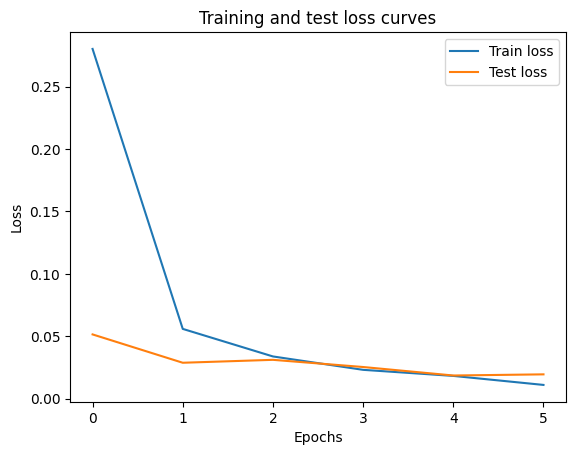

In [76]:
plt.plot(eposhs_count, train_losses, label="Train loss")
plt.plot(eposhs_count, test_losses, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.Figure(figsize=(15,15))

plt.xlabel("Epochs")
plt.legend();

In [77]:
torch.save(net.state_dict(), "resnet_weights1.pth")

In [78]:
print(dataset.classes)

['benign', 'malignant', 'normal']


In [79]:
model =models. resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)   
model.load_state_dict(torch.load("resnet_weights1.pth"))

<All keys matched successfully>

In [80]:
img_path = "nn.png"
img = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img = transform(img).unsqueeze(0).to(device)
model = model.to(device)
# prediction
model.eval()
with torch.no_grad():
    outputs = model(img)
    _, preds = torch.max(outputs, 1)

classes = ['benign', 'malignant', 'normal']
print(f"Prediction: {classes[preds.item()]}")

Prediction: normal
